In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

from google.colab import drive
drive.mount('/content/drive')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cuda:0


In [2]:

batch_size_train = 64
batch_size_test = 1000

MNIST_training = torchvision.datasets.MNIST('/content/drive/My Drive/CMPUT328_2020/Week08/MNIST_dataset/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.0,), (1.0,))]))

MNIST_test_set = torchvision.datasets.MNIST('/content/drive/My Drive/CMPUT328_2020/Week08//MNIST_dataset/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.0,), (1.0,))]))

# create a training and a validation set
MNIST_training_set, MNIST_validation_set = random_split(MNIST_training, [55000, 5000])


train_loader = torch.utils.data.DataLoader(MNIST_training_set,batch_size=batch_size_train, shuffle=True)

validation_loader = torch.utils.data.DataLoader(MNIST_validation_set,batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(MNIST_test_set,batch_size=batch_size_test, shuffle=True)

In [3]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.dtype)
print(example_targets.dtype)

torch.float32
torch.int64


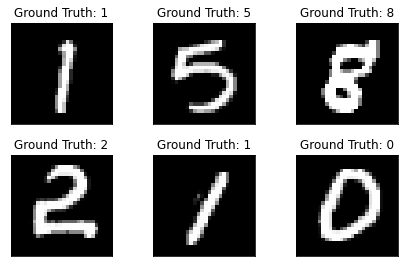

In [4]:

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

In [5]:
# Fully Connected AutoEncoder Architecture
class AE(torch.nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.fc1 = torch.nn.Linear(28*28, 300, True)
        self.fc2 = torch.nn.Linear(300, 20, True)
        self.fc3 = torch.nn.Linear(20, 300, True)
        self.fc4 = torch.nn.Linear(300,28*28, True)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        x = x.view(x.size(0), 1, 28, 28)
        return x

    def code(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

In [6]:
#https://www.kaggle.com/ljlbarbosa/convolution-autoencoder-pytorch

# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 1 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  
        # conv layer (depth from 16 --> 4), 3x3 kernels
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)

    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation
        
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.t_conv2(x))
                
        return x


In [7]:
n_epochs=10
train_losses = []
train_counter = []
validation_losses = []
validation_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [8]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data = data.to(device)
    target = target.to(device)
    optimizer.zero_grad()
    output = network(data)
    loss = F.mse_loss(output, data)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), '/content/drive/My Drive/CMPUT328_2020/Week08/MNIST_NN_results/model.pth')
      torch.save(optimizer.state_dict(), '/content/drive/My Drive/CMPUT328_2020/Week08/MNIST_NN_results/optimizer.pth')

In [9]:
def validation():
  network.eval()
  validation_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in validation_loader:
      data = data.to(device)
      target = target.to(device)
      output = network(data)
      validation_loss += F.mse_loss(output, data).item()
  validation_loss /= len(validation_loader.dataset)
  validation_losses.append(validation_loss)
  print('\nValidation set: Avg. loss: {:.6f}\n'.format(validation_loss))

In [10]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data = data.to(device)
      target = target.to(device)
      output = network(data)
      test_loss += F.mse_loss(output, data).item()
  test_loss /= len(test_loader.dataset)
  print('\nTest set: Avg. loss: {:.6f}\n'.format(test_loss))

In [11]:
log_interval = 200
learning_rate=0.001
n_epochs = 100

network = AE().to(device)
#network = ConvAutoencoder().to(device)


optimizer = optim.Adam(network.parameters(), lr=learning_rate, amsgrad=True)

validation()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  validation()
test()


Validation set: Avg. loss: 0.003665

Train Epoch: 1 [0/55000 (0%)]	Loss: 0.232224
Train Epoch: 1 [12800/55000 (23%)]	Loss: 0.038521
Train Epoch: 1 [25600/55000 (47%)]	Loss: 0.027927
Train Epoch: 1 [38400/55000 (70%)]	Loss: 0.024526
Train Epoch: 1 [51200/55000 (93%)]	Loss: 0.021713

Validation set: Avg. loss: 0.000356

Train Epoch: 2 [0/55000 (0%)]	Loss: 0.022108
Train Epoch: 2 [12800/55000 (23%)]	Loss: 0.021529
Train Epoch: 2 [25600/55000 (47%)]	Loss: 0.020580
Train Epoch: 2 [38400/55000 (70%)]	Loss: 0.019456
Train Epoch: 2 [51200/55000 (93%)]	Loss: 0.021694

Validation set: Avg. loss: 0.000310

Train Epoch: 3 [0/55000 (0%)]	Loss: 0.019505
Train Epoch: 3 [12800/55000 (23%)]	Loss: 0.017301
Train Epoch: 3 [25600/55000 (47%)]	Loss: 0.018536
Train Epoch: 3 [38400/55000 (70%)]	Loss: 0.018155
Train Epoch: 3 [51200/55000 (93%)]	Loss: 0.018747

Validation set: Avg. loss: 0.000286

Train Epoch: 4 [0/55000 (0%)]	Loss: 0.019680
Train Epoch: 4 [12800/55000 (23%)]	Loss: 0.015860
Train Epoch: 4 [25

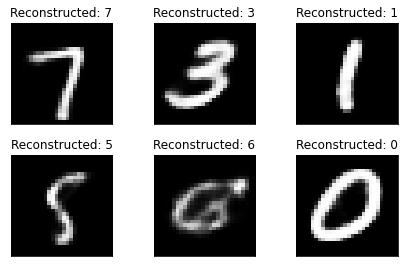

In [12]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

recons_data = network(example_data.to(device)).cpu().detach().numpy()

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(recons_data[i][0], cmap='gray', interpolation='none')
  plt.title("Reconstructed: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

In [13]:
# Let's use the codes given by autoencode in a knn classifier
from sklearn.neighbors import KNeighborsClassifier

cnt=0
for batch_idx, (data, target) in enumerate(train_loader):
  data = data.to(device)
  if cnt==0:
    X = network.code(data).cpu().detach().numpy()
    y = target.numpy()
    cnt=1
  else:
    X = np.concatenate((X,network.code(data).cpu().detach().numpy()),axis=0)
    y = np.concatenate((y,target.numpy()))


neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X, y)

correct = 0
for batch_idx, (test_data, test_target) in enumerate(test_loader):
  test_data = test_data.to(device)
  x_test = network.code(test_data).cpu().detach().numpy()
  y_pred = neigh.predict(x_test)
  correct += np.sum(test_target.numpy()==y_pred)
print("Accuracy on test data:",correct/100,"percent.")

Accuracy on test data: 95.61 percent.
